In [1]:
#cargamos librerias

import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from tkinter import Tk
from tkinter.filedialog import askopenfilename
from PIL import Image
import os

# Suprimir todos los warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Cargar el Modelo de Metadatos y el Dataset


# Cargar el modelo entrenado con los metadatos
metadata_model_path = '/Users/luiseduardogarciablanco/Desktop/bootcamp/Flask_proyecto_cancer_jpg_data/static/model/metadata_model.pkl'
metadata_model = joblib.load(metadata_model_path)

# Cargar el modelo entrenado con las imágenes
image_model_path = '/Users/luiseduardogarciablanco/Desktop/bootcamp/Flask_proyecto_cancer_jpg_data/static/model/prueba_modelo_encadenado.pkl'  # Modelo que entrenaste con imágenes y predicciones crudas
image_model = load_model(image_model_path)

# Cargar el dataset con los metadatos
df = pd.read_csv('/Users/luiseduardogarciablanco/Desktop/bootcamp/Flask_proyecto_cancer_jpg_data/static/data/dataset_flask.csv')

# Mostrar las primeras filas para verificar que está cargado correctamente
print(df.head())

2024-09-07 14:31:52.748604: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-09-07 14:31:52.748625: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-09-07 14:31:52.748629: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-09-07 14:31:52.748657: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-07 14:31:52.748671: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


        isic_id  target  age_approx  clin_size_long_diam_mm   tbp_lv_A  \
0  ISIC_5046058       0        30.0                    2.82  18.757753   
1  ISIC_1577832       0        65.0                    2.51  29.707480   
2  ISIC_6818565       0        50.0                    2.82  25.479410   
3  ISIC_6565046       0        45.0                    2.70  19.841030   
4  ISIC_2090145       1        80.0                    4.68  12.029640   

   tbp_lv_Aext   tbp_lv_B  tbp_lv_Bext   tbp_lv_C  tbp_lv_Cext  ...  \
0    14.880676  25.339839    25.757803  31.527143    29.747251  ...   
1    26.097380  33.122510    34.903450  44.493090    43.581230  ...   
2    23.152320  28.198960    27.536280  38.005010    35.976050  ...   
3    14.238560  31.527880    29.378060  37.251490    32.646700  ...   
4    14.353230  15.753490    22.444350  19.821320    26.641400  ...   

   onehot_33  onehot_34  onehot_35  onehot_36  onehot_37  onehot_38  \
0          0          0          0          0          1 

In [3]:
# Abrir una ventana para seleccionar la imagen
Tk().withdraw()  # Ocultar la ventana principal de Tkinter
image_path = askopenfilename(title="Selecciona una imagen", filetypes=[("Archivos de imagen", "*.jpg")])

# Mostrar la ruta de la imagen seleccionada
print(f"Imagen seleccionada: {image_path}")

Imagen seleccionada: /Users/luiseduardogarciablanco/Desktop/nueva data cancer/test web/jpg_ensambled_model/ISIC_0429927.jpg


In [4]:
#Buscar los Datos Correspondientes en el Dataset

# Obtener el nombre del archivo de la imagen sin la extensión .jpg
image_name = os.path.splitext(os.path.basename(image_path))[0]

# Buscar los datos correspondientes en el DataFrame por isic_id
image_metadata = df[df['isic_id'] == image_name]

# Verificar si se encontró la entrada en el dataset
if image_metadata.empty:
    print(f"No se encontró metadatos para la imagen {image_name} en el dataset.")
else:
    print(f"Metadatos encontrados para la imagen {image_name}:")
    print(image_metadata)

Metadatos encontrados para la imagen ISIC_0429927:
          isic_id  target  age_approx  clin_size_long_diam_mm  tbp_lv_A  \
486  ISIC_0429927       0        55.0                     5.1  22.12542   

     tbp_lv_Aext  tbp_lv_B  tbp_lv_Bext  tbp_lv_C  tbp_lv_Cext  ...  \
486     18.63486  27.49076      31.7618  35.28847     36.82486  ...   

     onehot_33  onehot_34  onehot_35  onehot_36  onehot_37  onehot_38  \
486          1          0          0          0          0          0   

     onehot_39  onehot_40  onehot_41  onehot_42  
486          0          0          1          0  

[1 rows x 274 columns]


In [5]:
# Extraer las características necesarias para la predicción (excluyendo 'isic_id' y 'target')
X_metadata = image_metadata.drop(columns=['isic_id', 'target'])

# Predecir con el modelo de metadatos, obteniendo las probabilidades
metadata_prediction = metadata_model.predict_proba(X_metadata)[:, 1]  # Para obtener solo la probabilidad de la clase 1

# Mostrar la predicción cruda obtenida del modelo de metadatos
print(f"Predicción cruda (probabilidad) del modelo de metadatos: {metadata_prediction}")

Predicción cruda (probabilidad) del modelo de metadatos: [0.02570831]


In [6]:
#Predecir con el Modelo de Imágenes Combinado con el resultado de los modelos de metadatos
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Preprocesar la imagen seleccionada para el modelo de imágenes
def preprocess_image(image_path, size=(256, 256)):
    img = load_img(image_path, target_size=size)
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)  # Normalización específica de ResNet50
    img_array = np.expand_dims(img_array, axis=0)  # Añadir la dimensión para el batch
    return img_array

# Preprocesar la imagen seleccionada
image_array = preprocess_image(image_path)

# Combinar la predicción cruda del modelo de metadatos con la imagen para hacer la predicción final
combined_input = [image_array, np.array(metadata_prediction).reshape(-1, 1)]

# Realizar la predicción con el modelo entrenado con imágenes y metadatos
final_prediction = image_model.predict(combined_input)

# Mostrar el resultado de la predicción final
print(f"Resultado final de la predicción: {final_prediction}")

2024-09-07 14:32:19.148599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step
Resultado final de la predicción: [[0.00199664]]


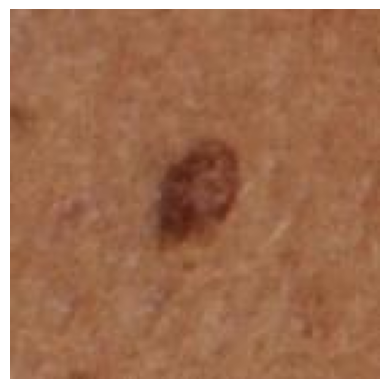

Edad aproximada: 55.0 años
Cantidad de lesiones en el mismo paciente: 661
Diámetro de la lesión: 5.1 mm
Índice de asimetría del color: 0.389
Predicción del modelo: El modelo no detecta una alta probabilidad de melanoma maligno.
Grado de confianza del modelo para este caso: 99.80%


In [7]:
import matplotlib.pyplot as plt
from PIL import Image

# Función para mostrar la imagen seleccionada
def display_image(image_path):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')  # Ocultar los ejes
    plt.show()

# Función para mostrar la información adicional del paciente con formato decimal
def display_patient_info(df, isic_id):
    patient_info = df[df['isic_id'] == isic_id][['age_approx', 'count_per_patient', 'clin_size_long_diam_mm', 'volume_approximation_3d', 'color_asymmetry_index']]

    if not patient_info.empty:
        print(f"Edad aproximada: {patient_info['age_approx'].values[0]} años")
        print(f"Cantidad de lesiones en el mismo paciente: {patient_info['count_per_patient'].values[0]}")
        print(f"Diámetro de la lesión: {patient_info['clin_size_long_diam_mm'].values[0]} mm")
        print(f"Índice de asimetría del color: {patient_info['color_asymmetry_index'].values[0]:.3f}")  # Formato a 3 decimales
    else:
        print("No se encontró información adicional del paciente.")

# Interpretar el resultado de la predicción y mostrar el grado de confianza
def interpret_prediction(final_prediction):
    if final_prediction < 0.5:
        result_message = "El modelo no detecta una alta probabilidad de melanoma maligno."
    else:
        result_message = "El modelo ha detectado una alta probabilidad de melanoma maligno."
    
    # El grado de confianza es el valor absoluto de la predicción con respecto a la clase prevista
    confidence = final_prediction if final_prediction >= 0.5 else 1 - final_prediction
    print(f"Predicción del modelo: {result_message}")
    print(f"Grado de confianza del modelo para este caso: {confidence * 100:.2f}%")

# Uso del código adaptado:
# Mostrar la imagen seleccionada
display_image(image_path)

# Mostrar la información adicional del paciente
display_patient_info(df, image_name)

# Interpretar el resultado de la predicción con el valor numérico
final_prediction = float(final_prediction)  # Asegúrate de que esta variable contenga la predicción real (entre 0 y 1)
interpret_prediction(final_prediction)